In [1]:
import sys
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split


print("Python:", sys.version.splitlines()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)

Python: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
pandas: 2.1.4
numpy: 1.26.4
scikit-learn: 1.4.2


In [2]:
raw_path = "C:/Graduation Project/AI_Cybersecurity/cicids2017.csv"
df = pd.read_csv(raw_path)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


In [3]:
#clean column names
def clean_column_names(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()    #remove leading or trailing spaces
        .str.lower()    #lowercase everything
        .str.replace('[^a-z0-9]', '_', regex=True)  #replace nonalphanumeric with _
        .str.replace('_+', '_', regex=True) #no repeated _
    )
    return df
df = clean_column_names(df)
df.head()

,destination_port,flow_duration,total_fwd_packets,total_length_of_fwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,...,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_max,active_min,idle_mean,idle_max,idle_min,attack_type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


In [4]:
# Display summary statistics
df.select_dtypes(include='number').describe().T  # Transpose for easier reading

,count,mean,std,min,25%,50%,75%,max
destination_port,2520751.0,8.690744e+03,1.901294e+04,0.000000e+00,53.000000,80.000000,4.430000e+02,6.553500e+04
flow_duration,2520751.0,1.659032e+07,3.523140e+07,-1.300000e+01,208.000000,50620.000000,5.332968e+06,1.200000e+08
total_fwd_packets,2520751.0,1.025880e+01,7.943824e+02,1.000000e+00,2.000000,2.000000,6.000000e+00,2.197590e+05
total_length_of_fwd_packets,2520751.0,6.065243e+02,1.011595e+04,0.000000e+00,12.000000,66.000000,3.320000e+02,1.290000e+07
fwd_packet_length_max,2520751.0,2.311993e+02,7.563122e+02,0.000000e+00,6.000000,40.000000,2.020000e+02,2.482000e+04
fwd_packet_length_min,2520751.0,1.920377e+01,6.079887e+01,0.000000e+00,0.000000,2.000000,3.700000e+01,2.325000e+03
fwd_packet_length_mean,2520751.0,6.350189e+01,1.955512e+02,0.000000e+00,6.000000,36.250000,5.200000e+01,5.940857e+03
fwd_packet_length_std,2520751.0,7.732029e+01,2.968824e+02,0.000000e+00,0.000000,0.000000,7.419280e+01,7.125597e+03
bwd_packet_length_max,2520751.0,9.749253e+02,2.038152e+03,0.000000e+00,6.000000,97.000000,7.460000e+02,1.953000e+04
bwd_packet_length_min,2520751.0,4.316019e+01,7.088017e+01,0.000000e+00,0.000000,0.000000,8.200000e+01,2.896000e+03


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520751 entries, 0 to 2520750
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   flow_duration                int64  
 2   total_fwd_packets            int64  
 3   total_length_of_fwd_packets  int64  
 4   fwd_packet_length_max        int64  
 5   fwd_packet_length_min        int64  
 6   fwd_packet_length_mean       float64
 7   fwd_packet_length_std        float64
 8   bwd_packet_length_max        int64  
 9   bwd_packet_length_min        int64  
 10  bwd_packet_length_mean       float64
 11  bwd_packet_length_std        float64
 12  flow_bytes_s                 float64
 13  flow_packets_s               float64
 14  flow_iat_mean                float64
 15  flow_iat_std                 float64
 16  flow_iat_max                 int64  
 17  flow_iat_min                 int64  
 18  fwd_iat_total                int64  
 19  

# Handling missing values

In [6]:
# 1. Check for NaN, None, and null values
missing_values = df.isnull().sum()
missing_values

destination_port               0
flow_duration                  0
total_fwd_packets              0
total_length_of_fwd_packets    0
fwd_packet_length_max          0
fwd_packet_length_min          0
fwd_packet_length_mean         0
fwd_packet_length_std          0
bwd_packet_length_max          0
bwd_packet_length_min          0
bwd_packet_length_mean         0
bwd_packet_length_std          0
flow_bytes_s                   0
flow_packets_s                 0
flow_iat_mean                  0
flow_iat_std                   0
flow_iat_max                   0
flow_iat_min                   0
fwd_iat_total                  0
fwd_iat_mean                   0
fwd_iat_std                    0
fwd_iat_max                    0
fwd_iat_min                    0
bwd_iat_total                  0
bwd_iat_mean                   0
bwd_iat_std                    0
bwd_iat_max                    0
bwd_iat_min                    0
fwd_header_length              0
bwd_header_length              0
fwd_packet

In [7]:
# 2. Check for placeholder values
# Check for -1 values
print("\nColumns with -1 values:")
for col in df.select_dtypes(include=[np.number]).columns:
    count = (df[col] == -1).sum()
    if count > 0:
        percentage = (count / len(df)) * 100
        print(f"{col}: {count} occurrences ({percentage:.2f}%)")


Columns with -1 values:
flow_duration: 101 occurrences (0.00%)
flow_iat_mean: 101 occurrences (0.00%)
flow_iat_max: 101 occurrences (0.00%)
flow_iat_min: 2738 occurrences (0.11%)
fwd_iat_min: 15 occurrences (0.00%)
init_win_bytes_forward: 911012 occurrences (36.14%)
init_win_bytes_backward: 1215622 occurrences (48.22%)
min_seg_size_forward: 1 occurrences (0.00%)


In [8]:
# find negative values
neg_report = {}

for col in df.columns:
    if df[col].dtype != "object":  
        negatives = (df[col] < 0).sum()
        total = len(df[col])
        percent = negatives / total * 100
        
        if negatives > 0:
            neg_report[col] = {
                "negatives": negatives,
                "percent": percent
            }


for col, stats in neg_report.items():
    print(f"{col:<30} | negatives: {stats['negatives']:<8} | {stats['percent']:.4f}%")

flow_duration                  | negatives: 107      | 0.0042%
flow_bytes_s                   | negatives: 78       | 0.0031%
flow_packets_s                 | negatives: 107      | 0.0042%
flow_iat_mean                  | negatives: 107      | 0.0042%
flow_iat_max                   | negatives: 107      | 0.0042%
flow_iat_min                   | negatives: 2875     | 0.1141%
fwd_iat_min                    | negatives: 17       | 0.0007%
fwd_header_length              | negatives: 35       | 0.0014%
bwd_header_length              | negatives: 22       | 0.0009%
init_win_bytes_forward         | negatives: 911012   | 36.1405%
init_win_bytes_backward        | negatives: 1215622  | 48.2246%
min_seg_size_forward           | negatives: 35       | 0.0014%


In [9]:
df = df.drop(columns = ['init_win_bytes_forward','init_win_bytes_backward'])

In [10]:
# 3. Check for infinity values
numeric_cols = df.select_dtypes(include = np.number).columns
inf_count = np.isinf(df[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Series([], dtype: int64)


In [11]:
# replace corrupt negative values with nan
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0, 0)
# replace inf values with nan
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], 0)
df[numeric_cols] = df[numeric_cols].fillna(0)

In [12]:
#drop rows that have missing values
df = df.dropna()

# Handling duplicate values

In [13]:
duplicated_rows = df[df.duplicated()]
print(f'Number of duplicates: {len(duplicated_rows)}')
df.shape

Number of duplicates: 47836


(2520751, 51)

In [14]:
# remove duplicates but keep first occurrence
df = df.drop_duplicates(keep="first")
df.shape

(2472915, 51)

# Label Encoding

In [15]:
# Check unique values in the Label column (attack types)
print(df['attack_type'].value_counts())

attack_type
Normal Traffic    2048211
DoS                192875
DDoS               128014
Port Scanning       90694
Brute Force          9086
Web Attacks          2091
Bots                 1944
Name: count, dtype: int64


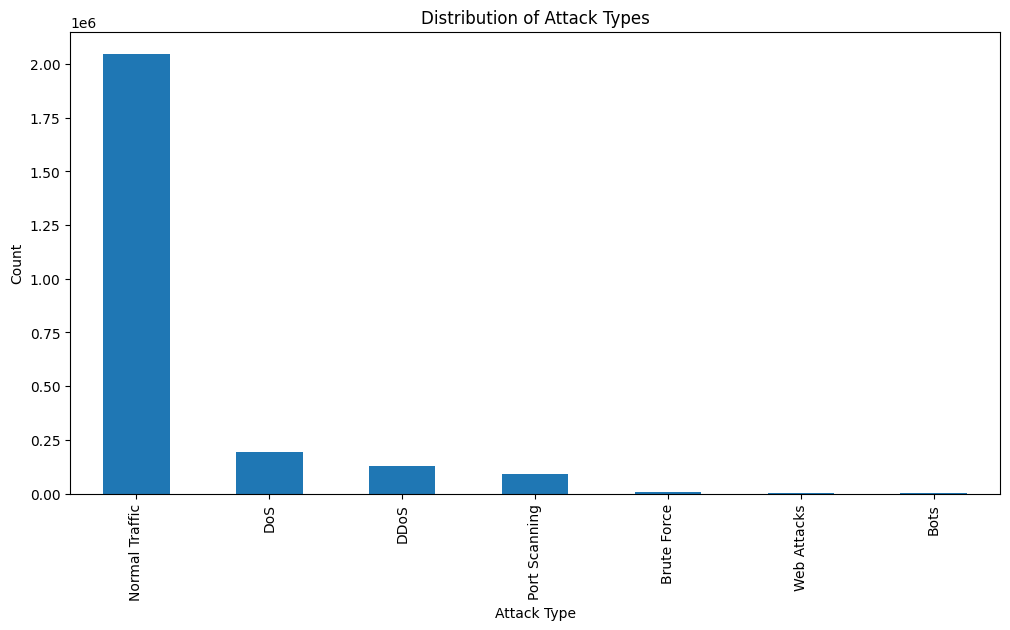

In [16]:
# visualize attack types distribution
attack_counts = df['attack_type'].value_counts()
plt.figure(figsize=(12, 6))
attack_counts.plot(kind='bar')
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.show()

In [17]:
# Create Binary Labels
label_col = 'attack_type'  

# Standardize text inside label
df[label_col] = df[label_col].astype(str).str.strip()

# Create binary label: 0 = BENIGN, 1 = anything else (attack)
df['binary_label'] = np.where(df[label_col].str.contains("Normal Traffic", case=False), 0, 1)

print("\nOriginal label distribution:")
print(f"\n0 (Normal): {(df['binary_label'] == 0).sum()}")
print(f"1 (Attack): {(df['binary_label'] == 1).sum()}")
print(f"Imbalance ratio: {(df['binary_label'] == 0).sum() / (df['binary_label'] == 1).sum():.2f}:1")

# Drop original label column
df = df.drop(columns=[label_col])


Original label distribution:

0 (Normal): 2048211
1 (Attack): 424704
Imbalance ratio: 4.82:1


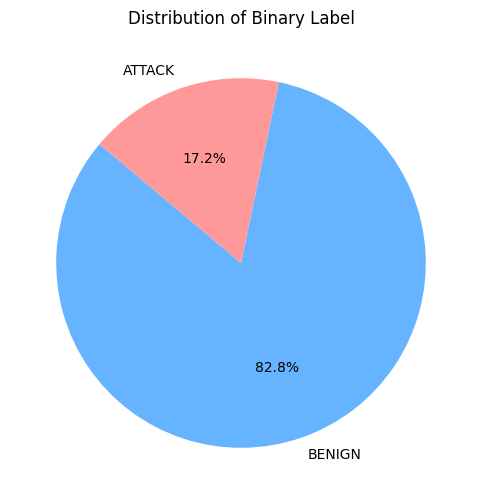

In [18]:
# pie chart
label_counts = df['binary_label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=['BENIGN', 'ATTACK'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Distribution of Binary Label')
plt.show()

In [19]:
# Display summary statistics
df.select_dtypes(include='number').describe().T  # Transpose for easier reading

,count,mean,std,min,25%,50%,75%,max
destination_port,2472915.0,8.718243e+03,1.903704e+04,0.0,53.000000,80.000000,4.430000e+02,6.553500e+04
flow_duration,2472915.0,1.690816e+07,3.549328e+07,0.0,218.000000,55314.000000,5.447257e+06,1.200000e+08
total_fwd_packets,2472915.0,1.042265e+01,8.020280e+02,1.0,2.000000,2.000000,6.000000e+00,2.197590e+05
total_length_of_fwd_packets,2472915.0,6.180760e+02,1.021297e+04,0.0,24.000000,68.000000,3.400000e+02,1.290000e+07
fwd_packet_length_max,2472915.0,2.355372e+02,7.629364e+02,0.0,6.000000,41.000000,2.100000e+02,2.482000e+04
fwd_packet_length_min,2472915.0,1.951815e+01,6.133844e+01,0.0,0.000000,2.000000,3.700000e+01,2.325000e+03
fwd_packet_length_mean,2472915.0,6.463560e+01,1.972553e+02,0.0,6.000000,37.000000,5.273333e+01,5.940857e+03
fwd_packet_length_std,2472915.0,7.876253e+01,2.995494e+02,0.0,0.000000,0.000000,7.675180e+01,7.125597e+03
bwd_packet_length_max,2472915.0,9.937709e+02,2.053218e+03,0.0,6.000000,100.000000,8.320000e+02,1.953000e+04
bwd_packet_length_min,2472915.0,4.398371e+01,7.131175e+01,0.0,0.000000,0.000000,8.400000e+01,2.896000e+03


In [20]:
print(df.shape)
print(df.columns)

(2472915, 51)
Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_length_of_fwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_s', 'flow_packets_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_header_length', 'bwd_header_length',
       'fwd_packets_s', 'bwd_packets_s', 'min_packet_length',
       'max_packet_length', 'packet_length_mean', 'packet_length_std',
       'packet_length_variance', 'fin_flag_count', 'psh_flag_count',
       'ack_flag_count', 'average_packet_size', 'subflow_fwd_bytes',
       'act_data_pkt_fwd', 'min_seg_size_forward', 'activ

In [21]:
x = df.drop(columns=['binary_label'])
y = df['binary_label']

In [22]:
#Train set: only benign samples = model learns normal behavior
#Test set: both benign + attacks = evaluate detection

#separate benign and attack
x_benign = x[y==0]
x_attack = x[y==1]

x_train, x_val = train_test_split(x_benign, test_size=0.2, random_state=42)
        
        
x_test = np.vstack([x_val, x_attack])   #test on 20% x_val + attacks 
y_test = np.hstack([np.zeros(len(x_val)), np.ones(len(x_attack))])

In [23]:
# find mean from train set and fill nans (we're doing this step now to avoid data leakage earlier)
# this ensures no info from validation or test leaks into training

train_means = x_train.mean()
x_train = x_train.fillna(train_means)
x_val = x_val.fillna(train_means)
# x_test is numpy array
x_test = np.where(np.isnan(x_test), train_means.values, x_test)

In [24]:
# detect outliers with iqr

Q1 = np.percentile(x_train, 25, axis=0)
Q3 = np.percentile(x_train, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers per feature
outlier_counts = ((x_train < lower_bound) | (x_train > upper_bound)).sum(axis=0)
outlier_percent = outlier_counts / x_train.shape[0] * 100


outliers_df = pd.DataFrame({
    'outlier_count': outlier_counts,
    'outlier_percent': outlier_percent
})


pd.set_option('display.max_rows', None)     

display(outliers_df.sort_values('outlier_percent', ascending=False))

,outlier_count,outlier_percent
bwd_packet_length_std,392275,23.940111
flow_iat_std,388422,23.704967
fwd_iat_max,383677,23.415385
flow_iat_max,382902,23.368087
flow_duration,380019,23.192141
fwd_iat_total,376372,22.969569
fwd_iat_mean,373582,22.799298
destination_port,369091,22.525217
fwd_iat_std,362724,22.136646
packet_length_variance,354334,21.624614


# Handeling Outliers

In [25]:
# Apply log1p transform to reduce outliers
x_train_log = np.log1p(x_train)
x_val_log   = np.log1p(x_val)
x_test_log  = np.log1p(x_test)

# Scaling

In [26]:
# Robust scaling
robust_scaler = RobustScaler()
x_train_robust = robust_scaler.fit_transform(x_train_log)
x_val_robust   = robust_scaler.transform(x_val_log)
x_test_robust  = robust_scaler.transform(x_test_log)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [27]:
# standard scaling
standard_scaler = StandardScaler()
x_train_scaled = standard_scaler.fit_transform(x_train_robust)
x_val_scaled   = standard_scaler.transform(x_val_robust)
x_test_scaled  = standard_scaler.transform(x_test_robust)

In [28]:
def summary_arr(name, arr):
    print(f"\n{name}:")
    print(" shape:", arr.shape)
    print(" NANs:", np.isnan(arr).sum())
    print(" infs:", np.isinf(arr).sum())
    print(" mean:", float(np.mean(arr)))
    print(" std:", float(np.std(arr)))
    print(" min:", float(np.min(arr)))
    print(" 25%:", float(np.percentile(arr, 25)))
    print(" median:", float(np.percentile(arr, 50)))
    print(" 75%:", float(np.percentile(arr, 75)))
    print(" max:", float(np.max(arr)))

In [29]:
summary_arr("x_train", x_train_scaled)


x_train:
 shape: (1638568, 50)
 NANs: 0
 infs: 0
 mean: 2.0465036465659142e-17
 std: 1.0000000000000007
 min: -12.955019352846442
 25%: -0.6731943008830304
 median: -0.28012094102067825
 75%: 0.6947811400118061
 max: 12.99640417219524


In [30]:
# detect outliers with iqr
Q1 = np.percentile(x_train_scaled, 25, axis=0)
Q3 = np.percentile(x_train_scaled, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers per feature
outlier_counts = ((x_train_scaled < lower_bound) | (x_train_scaled > upper_bound)).sum(axis=0)
outlier_percent = outlier_counts / x_train_scaled.shape[0] * 100


outliers_df = pd.DataFrame({
    'outlier_count': outlier_counts,
    'outlier_percent': outlier_percent
})


pd.set_option('display.max_rows', None)     

display(outliers_df.sort_values('outlier_percent', ascending=False))

,outlier_count,outlier_percent
0,320768,19.576118
29,300475,18.337658
17,289424,17.663228
48,286891,17.508642
47,286891,17.508642
49,286891,17.508642
46,285946,17.450969
45,285946,17.450969
44,285946,17.450969
2,252999,15.440250


In [31]:
# statisc dscribe final datasets
summary_arr("x_train_scaled", x_train_scaled)
summary_arr("x_val_scaled", x_val_scaled)



x_train_scaled:
 shape: (1638568, 50)
 NANs: 0
 infs: 0
 mean: 2.0465036465659142e-17
 std: 1.0000000000000007
 min: -12.955019352846442
 25%: -0.6731943008830304
 median: -0.28012094102067825
 75%: 0.6947811400118061
 max: 12.99640417219524

x_val_scaled:
 shape: (409643, 50)
 NANs: 0
 infs: 0
 mean: -0.00024474245281858346
 std: 0.9996695920936334
 min: -12.955019352846442
 25%: -0.6731943008830304
 median: -0.2796287845327967
 75%: 0.6926215357691698
 max: 12.974846603756825


In [32]:
import joblib

project_root = r"C:/Graduation Project/AI_Cybersecurity"
processed_path = os.path.join(project_root, "Data", "Processed")
os.makedirs(processed_path, exist_ok=True)

joblib.dump(x_train_scaled, os.path.join(processed_path, "train_scaled.pkl"))
joblib.dump(x_val_scaled, os.path.join(processed_path, "val_scaled.pkl"))
joblib.dump(x_test_scaled, os.path.join(processed_path, "test_scaled.pkl"))
joblib.dump(y_test, os.path.join(processed_path, "test_labels.pkl"))

['C:/Graduation Project/AI_Cybersecurity\\Data\\Processed\\test_labels.pkl']

In [33]:
#save the scaler

joblib.dump(standard_scaler, os.path.join(processed_path, "scaler_cicids.pkl"))

['C:/Graduation Project/AI_Cybersecurity\\Data\\Processed\\scaler_cicids.pkl']

In [ ]:
# import pandas as pd
# import joblib 
# import os
# project_root = r"C:/Graduation Project/AI_Cybersecurity"
# processed_path = os.path.join(project_root, "Data", "Processed")

# test_scaled  = joblib.load(os.path.join(processed_path, "test_scaled.pkl"))
# test_df = pd.DataFrame(test_scaled)

# sample_df = test_df.sample(n=50, random_state=42)

# sample_df.to_csv("samples.csv", index=False)